In [5]:
import torch
import torch.nn as nn
from torchvision import datasets
import numpy as np
from linear_cca import linear_cca
from torch.utils.data import BatchSampler, SequentialSampler, Dataset
from DeepCCAModels import DeepCCA
from main import Solver
from utils_deepcca import load_data, svm_classify
import matplotlib.pyplot as plt
try:
    import cPickle as thepickle
except ImportError:
    import _pickle as thepickle
    
from sklearn.cross_decomposition import CCA
import scipy.io as sio
    
import gzip
import numpy as np
torch.set_default_tensor_type(torch.DoubleTensor)

from multiview.embed.gcca import GCCA


In [6]:
%matplotlib inline
plt.style.use("ggplot")
%config InlineBackend.figure_format = 'svg'
np.set_printoptions(suppress=True) # don't use scientific [e.g. 5e10] notation

In [7]:
# Parameters Section
device = torch.device('cpu')
print("Using", torch.cuda.device_count(), "GPUs")

# the path to save the final learned features
save_to = './new_features.gz'

# the size of the new space learned by the model (number of the new features)
outdim_size = 50

# size of the input for view 1 and view 2
input_shape1 = 392
input_shape2 = 392

# number of layers with nodes in each one
# layer_sizes1 = [1024, 1024, 1024, outdim_size]
# layer_sizes2 = [1024, 1024, 1024, outdim_size]
layer_sizes1 = [2038, outdim_size]
layer_sizes2 = [1608, outdim_size]

# the parameters for training the network
learning_rate = 1e-3
epoch_num = 10
batch_size = 800

# the regularization parameter of the network
# seems necessary to avoid the gradient exploding especially when non-saturating activations are used
reg_par = 1e-5

# specifies if all the singular values should get used to calculate the correlation or just the top outdim_size ones
# if one option does not work for a network or dataset, try the other one
use_all_singular_values = False

# if a linear CCA should get applied on the learned features extracted from the networks
# it does not affect the performance on noisy MNIST significantly
apply_linear_cca = True
# end of parameters section
############

### Don't need this right now since not using noisy mnist
# Each view is stored in a gzip file separately. They will get downloaded the first time the code gets executed.
# Datasets get stored under the datasets folder of user's Keras folder
# normally under [Home Folder]/.keras/datasets/
# data1 = load_data('./noisymnist_view1.gz')
# data2 = load_data('./noisymnist_view2.gz')

Using 0 GPUs


In [8]:
def mnist_left_right():
    mnist_train = Dataset.mnistDataset = datasets.MNIST("./mnist", train=True, download=True)
    mnist_test = datasets.MNIST("./mnist/", train=False, download=True)

    data1 = []
    data2 = []

    #### get train data
    temp_array1 = np.zeros((50000, 14*28))
    temp_array2 = np.zeros((50000, 14*28))
    labels = []
    for i in range(len(mnist_train)-10000): # 
        img, label = mnist_train[i]
        labels.append(label)
        img = np.array(img) / 255
        image1, image2 = img[:,:14], img[:,14:]
        temp_array1[i,:] = np.reshape(image1, (1,14*28))
        temp_array2[i,:] = np.reshape(image2, (1,14*28))

    labels = np.array(labels)
    temp_array1 = torch.tensor(temp_array1)
    temp_array2 = torch.tensor(temp_array2)
    data1.append((temp_array1, labels))
    data2.append((temp_array2, labels))
    #### get eval data
    temp_array1 = np.zeros((10000, 14*28))
    temp_array2 = np.zeros((10000, 14*28))
    labels = []
    for i in range(10000): # 
        img, label = mnist_train[i+50000]
        labels.append(label)
        img = np.array(img) / 255
        image1, image2 = img[:,:14], img[:,14:]
        temp_array1[i,:] = np.reshape(image1, (1,14*28))
        temp_array2[i,:] = np.reshape(image2, (1,14*28))
    labels = np.array(labels)
    temp_array1 = torch.tensor(temp_array1)
    temp_array2 = torch.tensor(temp_array2)
    data1.append((temp_array1, labels))
    data2.append((temp_array2, labels))
    #### get test data
    temp_array1 = np.zeros((10000, 14*28))
    temp_array2 = np.zeros((10000, 14*28))
    labels = []
    for i in range(10000): # 
        img, label = mnist_test[i]
        labels.append(label)
        img = np.array(img) / 255
        image1, image2 = img[:,:14], img[:,14:]
        temp_array1[i,:] = np.reshape(image1, (1,14*28))
        temp_array2[i,:] = np.reshape(image2, (1,14*28))
    labels = np.array(labels)
    temp_array1 = torch.tensor(temp_array1)
    temp_array2 = torch.tensor(temp_array2)
    data1.append((temp_array1, labels))
    data2.append((temp_array2, labels))
    return data1, data2

In [9]:
class SplitMNIST(Dataset):
  """
  Returns 2 views of the MNIST dataset. View 1 is the left half of each image,
  and View 2 is the right half.
  """
  def __init__(self, train=True):
    super().__init__()
    self.mnistDataset = datasets.MNIST("./mnist", train=train, download=True)

  def __len__(self):
    return len(self.mnistDataset)

  def __getitem__(self, idx):
    randomIndex = lambda: np.random.randint(len(self.mnistDataset))
    image1, label1 = self.mnistDataset[idx]

    image1 = np.array(image1) / 255
    image1, image2 = image1[:,:14], image1[:,14:]


    image1 = torch.FloatTensor(image1).unsqueeze(0)
    image2 = torch.FloatTensor(image2).unsqueeze(0)

    return (image1, image2, label1)


In [10]:
data1, data2 = mnist_left_right()

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...



Done!


In [12]:
# Building, training, and producing the new features by DCCA
model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                input_shape2, outdim_size, use_all_singular_values, device=device).double()
l_cca = None
if apply_linear_cca:
    l_cca = linear_cca()
solver = Solver(model, l_cca, outdim_size, epoch_num, batch_size,
                learning_rate, reg_par, device=device)
train1, train2 = data1[0][0], data2[0][0]
val1, val2 = data1[1][0], data2[1][0]
test1, test2 = data1[2][0], data2[2][0]

print(train1.shape)

[ INFO : 2020-02-17 14:40:12,720 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=392, out_features=2038, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=2038, out_features=50, bias=True)
      )
    )
    (model2): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=392, out_features=1608, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1608, out_features=50, bias=True)
      )
    )
  )
)
[ INFO : 2020-02-17 14:40:12,721 ] - RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 1e-05
)


torch.Size([50000, 392])


In [11]:
# val1=None
# test1=None
solver.fit(train1, train2, val1, val2, test1, test2)
# TODO: Save linear_cca model if needed

set_size = [0, train1.size(0), train1.size(
    0) + val1.size(0), train1.size(0) + val1.size(0) + test1.size(0)]
loss, outputs = solver.test(torch.cat([train1, val1, test1], dim=0), torch.cat(
    [train2, val2, test2], dim=0), apply_linear_cca)

SyntaxError: 'break' outside loop (<ipython-input-11-0370ec3dc77c>, line 18)

In [15]:
### Compute correlations between 50 features
new_data = []
# print(outputs)
for idx in range(3):
    new_data.append([outputs[0][set_size[idx]:set_size[idx + 1], :],
                     outputs[1][set_size[idx]:set_size[idx + 1], :], data1[idx][1]])

X1_train, X2_train, train_label = new_data[0]
X1_val, X2_val, valid_label = new_data[1]
X1_test, X2_test, test_label = new_data[2]

sum_corr_train = 0
for idx, (row1, row2) in enumerate(zip(X1_train, X2_train)):
    sum_corr_train += np.correlate(row1, row2)
    
corr_train = sum_corr_train/idx
    
sum_corr_test = 0
for idx, (row1, row2) in enumerate(zip(X1_test, X2_test)):
    sum_corr_test += np.correlate(row1, row2)
    
corr_test = sum_corr_test/idx
    

### Compute correlations of original images
X1_train, _ = data1[0]
X2_train, _ = data2[0]
X1_val, _ = data1[1]
X2_val, _ = data2[1]
X1_test, _ = data1[2]
X2_test, _ = data2[2]

X1_train = X1_train.numpy()
X2_train = X2_train.numpy()
X1_val = X1_val.numpy()
X2_val = X2_val.numpy()
X1_test = X1_test.numpy()
X2_test = X2_test.numpy()

sum_corr_train_orig = 0
for idx, (row1, row2) in enumerate(zip(X1_train, X2_train)):
    sum_corr_train_orig += np.correlate(row1, row2)
corr_train_orig = sum_corr_train_orig/idx    

sum_corr_test_orig = 0
for idx, (row1, row2) in enumerate(zip(X1_test, X2_test)):
    sum_corr_test_orig += np.correlate(row1, row2)
corr_test_orig = sum_corr_test_orig/idx

print("Cross-View Correlations before and after transformation")
print("Train: {} -> {}".format(corr_train_orig, corr_train))
print("Test: {} -> {}".format(corr_test_orig, corr_test))

Cross-View Correlations before and after transformation
Train: [3.18240939] -> [42.24101028]
Test: [3.17578552] -> [41.42938391]


In [16]:
# remove the examples that are all 0's so that GCCA can work
    
bad_rows = []
for idx, (row1, row2) in enumerate(zip(X1_train, X2_train)):
    if (not row1.any()) or (not row2.any()):  # one of the rows has only 0's
        bad_rows.append(idx)
        
X1_train_filtered = np.delete(X1_train, bad_rows, axis=0)
X2_train_filtered = np.delete(X2_train, bad_rows, axis=0)
print(X2_train_filtered.shape)

bad_rows = []
for idx, (row1, row2) in enumerate(zip(X1_test, X2_test)):
    if (not row1.any()) or (not row2.any()):  # one of the rows has only 0's
        bad_rows.append(idx)
        
X1_test_filtered = np.delete(X1_test, bad_rows, axis=0)
X2_test_filtered = np.delete(X2_test, bad_rows, axis=0)
print(X2_test_filtered.shape)

(49998, 392)
(10000, 392)


In [17]:
# Perform GCCA
gcca = GCCA(n_components=50)
Xs_train = [X1_train_filtered, X2_train_filtered]
Xs_test = [X1_test_filtered, X2_test_filtered]
latent_train1, latent_train2 = gcca.fit_transform(Xs_train)
latent_test1, latent_test2 = gcca.transform(Xs_test)

In [18]:
# Compute GCCA correlations
sum_corr_train = 0
for idx, (row1, row2) in enumerate(zip(latent_train1, latent_train2)):
    sum_corr_train += np.correlate(row1, row2)
    corr_train = sum_corr_train/idx    

sum_corr_test = 0
for idx, (row1, row2) in enumerate(zip(latent_test1, latent_test2)):
    sum_corr_test += np.correlate(row1, row2)
    corr_test = sum_corr_test/idx


print("Cross-View Correlations From GCCA")
print("Train: {}".format(corr_train))
print("Test: {}".format(corr_test))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


Cross-View Correlations From GCCA
Train: [16.03364892]
Test: [15.61656102]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


## Loop for running on different end dimensions

In [21]:
def loop_simulation(data1, data2, layer_sizes1, layer_sizes2, input_shape1, input_shape2):
    
    
    end_dimensions = [10, 20, 30, 40, 50]
    dcca_correlations_train = []
    dcca_correlations_test = []
    gcca_correlations_train = []
    gcca_correlations_test = []
    
    for outdim_size in end_dimensions:
        
        layer_sizes1[-1] = outdim_size
        layer_sizes2[-1] = outdim_size

        ############# Run DCCA ##############
        # Building, training, and producing the new features by DCCA
        model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                        input_shape2, outdim_size, use_all_singular_values, device=device).double()
        l_cca = None
        if apply_linear_cca:
            l_cca = linear_cca()
        solver = Solver(model, l_cca, outdim_size, epoch_num, batch_size,
                        learning_rate, reg_par, device=device)
        train1, train2 = data1[0][0], data2[0][0]
        val1, val2 = data1[1][0], data2[1][0]
        test1, test2 = data1[2][0], data2[2][0]
        # val1=None
        # test1=None
        solver.fit(train1, train2, val1, val2, test1, test2)
        # TODO: Save linear_cca model if needed

        set_size = [0, train1.size(0), train1.size(
            0) + val1.size(0), train1.size(0) + val1.size(0) + test1.size(0)]
        loss, outputs = solver.test(torch.cat([train1, val1, test1], dim=0), torch.cat(
            [train2, val2, test2], dim=0), apply_linear_cca)

        ############# Compute correlations ##############
        ### Compute correlations between M features
        new_data = []
        # print(outputs)
        for idx in range(3):
            new_data.append([outputs[0][set_size[idx]:set_size[idx + 1], :],
                             outputs[1][set_size[idx]:set_size[idx + 1], :], data1[idx][1]])

        X1_train, X2_train, train_label = new_data[0]
        X1_val, X2_val, valid_label = new_data[1]
        X1_test, X2_test, test_label = new_data[2]

        sum_corr_train = 0
        for idx, (row1, row2) in enumerate(zip(X1_train, X2_train)):
            sum_corr_train += np.correlate(row1, row2)

        corr_train = sum_corr_train/idx

        sum_corr_test = 0
        for idx, (row1, row2) in enumerate(zip(X1_test, X2_test)):
            sum_corr_test += np.correlate(row1, row2)

        corr_test = sum_corr_test/idx

        dcca_correlations_train.append(corr_train)
        dcca_correlations_test.append(corr_test)


        ############ Remove empty rows for gcca ############
        # remove the examples that are all 0's so that GCCA can work

        X1_train, _ = data1[0]
        X2_train, _ = data2[0]
        X1_val, _ = data1[1]
        X2_val, _ = data2[1]
        X1_test, _ = data1[2]
        X2_test, _ = data2[2]

        X1_train = X1_train.numpy()
        X2_train = X2_train.numpy()
        X1_val = X1_val.numpy()
        X2_val = X2_val.numpy()
        X1_test = X1_test.numpy()
        X2_test = X2_test.numpy()
        
        bad_rows = []
        for idx, (row1, row2) in enumerate(zip(X1_train, X2_train)):
            if (not row1.any()) or (not row2.any()):  # one of the rows has only 0's
                bad_rows.append(idx)

        X1_train_filtered = np.delete(X1_train, bad_rows, axis=0)
        X2_train_filtered = np.delete(X2_train, bad_rows, axis=0)
        print(X2_train_filtered.shape)

        bad_rows = []
        for idx, (row1, row2) in enumerate(zip(X1_test, X2_test)):
            if (not row1.any()) or (not row2.any()):  # one of the rows has only 0's
                bad_rows.append(idx)

        X1_test_filtered = np.delete(X1_test, bad_rows, axis=0)
        X2_test_filtered = np.delete(X2_test, bad_rows, axis=0)

        ############# Perform GCCA ################
        gcca = GCCA(n_components=outdim_size)
        Xs_train = [X1_train_filtered, X2_train_filtered]
        Xs_test = [X1_test_filtered, X2_test_filtered]
        latent_train1, latent_train2 = gcca.fit_transform(Xs_train)
        latent_test1, latent_test2 = gcca.transform(Xs_test)

#         cca = CCA(n_components=outdim_size)
#         (latent_train1, latent_train2) = cca.fit_transform(X1_train_filtered, X2_train_filtered)
#         (latent_test1, latent_test2) = cca.fit_transform(X1_test_filtered, X2_test_filtered)

        ############## Compute GCCA correlations ###############
        sum_corr_train = 0
        for idx, (row1, row2) in enumerate(zip(latent_train1, latent_train2)):
            sum_corr_train += np.correlate(row1, row2)
            corr_train = sum_corr_train/idx    

        sum_corr_test = 0
        for idx, (row1, row2) in enumerate(zip(latent_test1, latent_test2)):
            sum_corr_test += np.correlate(row1, row2)
            corr_test = sum_corr_test/idx

        gcca_correlations_train.append(corr_train)
        gcca_correlations_test.append(corr_test)
        
        print("finished loop: " + str(outdim_size))

    return end_dimensions, dcca_correlations_train, dcca_correlations_test, gcca_correlations_train, gcca_correlations_test


In [22]:
results = loop_simulation(data1, data2, layer_sizes1, layer_sizes2, input_shape1, input_shape2)

[ INFO : 2020-02-14 16:28:18,538 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=392, out_features=2038, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=2038, out_features=10, bias=True)
      )
    )
    (model2): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=392, out_features=1608, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1608, out_features=10, bias=True)
      )
    )
  )
)
[ INFO : 2020-02-14 16:28:18,539 ] - RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 1e-05
)
[ INFO : 2020-02-14 16:28:24,408 ] - Epoch 1: val_loss improved from 0.0000 to -8.7638, saving model to checkpoint.model
[ INFO : 2020-02-14 16:28:24,414 ] - Epoch 1/10 - time: 5.87 - training_loss: -8.1590 - val_loss: -8.7638
[ INF

Linear CCA started!
(49998, 392)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
[ INFO : 2020-02-14 16:29:33,657 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=392, out_features=2038, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=2038, out_features=20, bias=True)
      )
    )
    (model2): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=392, out_features=1608, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1608, out_features=20, bias=True)
      )
    )
  )
)
[ INFO : 2020-02-14 16:29:33,659 ] - RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight

finished loop: 10


[ INFO : 2020-02-14 16:29:39,716 ] - Epoch 1: val_loss improved from 0.0000 to -15.1272, saving model to checkpoint.model
[ INFO : 2020-02-14 16:29:39,722 ] - Epoch 1/10 - time: 6.06 - training_loss: -13.8257 - val_loss: -15.1272
[ INFO : 2020-02-14 16:29:45,995 ] - Epoch 2: val_loss improved from -15.1272 to -16.2319, saving model to checkpoint.model
[ INFO : 2020-02-14 16:29:46,000 ] - Epoch 2/10 - time: 6.28 - training_loss: -14.8488 - val_loss: -16.2319
[ INFO : 2020-02-14 16:29:52,337 ] - Epoch 3: val_loss improved from -16.2319 to -16.7326, saving model to checkpoint.model
[ INFO : 2020-02-14 16:29:52,342 ] - Epoch 3/10 - time: 6.34 - training_loss: -15.4715 - val_loss: -16.7326
[ INFO : 2020-02-14 16:29:58,591 ] - Epoch 4: val_loss improved from -16.7326 to -17.0211, saving model to checkpoint.model
[ INFO : 2020-02-14 16:29:58,596 ] - Epoch 4/10 - time: 6.25 - training_loss: -15.8736 - val_loss: -17.0211
[ INFO : 2020-02-14 16:30:04,912 ] - Epoch 5: val_loss improved from -17.0

Linear CCA started!
(49998, 392)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
[ INFO : 2020-02-14 16:30:49,824 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=392, out_features=2038, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=2038, out_features=30, bias=True)
      )
    )
    (model2): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=392, out_features=1608, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1608, out_features=30, bias=True)
      )
    )
  )
)
[ INFO : 2020-02-14 16:30:49,826 ] - RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight

finished loop: 20


[ INFO : 2020-02-14 16:30:56,004 ] - Epoch 1: val_loss improved from 0.0000 to -19.9979, saving model to checkpoint.model
[ INFO : 2020-02-14 16:30:56,011 ] - Epoch 1/10 - time: 6.18 - training_loss: -17.8674 - val_loss: -19.9979
[ INFO : 2020-02-14 16:31:02,579 ] - Epoch 2: val_loss improved from -19.9979 to -22.1819, saving model to checkpoint.model
[ INFO : 2020-02-14 16:31:02,584 ] - Epoch 2/10 - time: 6.57 - training_loss: -19.6507 - val_loss: -22.1819
[ INFO : 2020-02-14 16:31:09,287 ] - Epoch 3: val_loss improved from -22.1819 to -23.5496, saving model to checkpoint.model
[ INFO : 2020-02-14 16:31:09,293 ] - Epoch 3/10 - time: 6.71 - training_loss: -20.8707 - val_loss: -23.5496
[ INFO : 2020-02-14 16:31:15,986 ] - Epoch 4: val_loss improved from -23.5496 to -24.2365, saving model to checkpoint.model
[ INFO : 2020-02-14 16:31:15,992 ] - Epoch 4/10 - time: 6.70 - training_loss: -21.7381 - val_loss: -24.2365
[ INFO : 2020-02-14 16:31:22,722 ] - Epoch 5: val_loss improved from -24.2

Linear CCA started!
(49998, 392)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
[ INFO : 2020-02-14 16:32:08,148 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=392, out_features=2038, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=2038, out_features=40, bias=True)
      )
    )
    (model2): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=392, out_features=1608, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1608, out_features=40, bias=True)
      )
    )
  )
)
[ INFO : 2020-02-14 16:32:08,150 ] - RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight

finished loop: 30


[ INFO : 2020-02-14 16:32:14,712 ] - Epoch 1: val_loss improved from 0.0000 to -22.6809, saving model to checkpoint.model
[ INFO : 2020-02-14 16:32:14,718 ] - Epoch 1/10 - time: 6.56 - training_loss: -20.2502 - val_loss: -22.6809
[ INFO : 2020-02-14 16:32:21,637 ] - Epoch 2: val_loss improved from -22.6809 to -26.4292, saving model to checkpoint.model
[ INFO : 2020-02-14 16:32:21,643 ] - Epoch 2/10 - time: 6.92 - training_loss: -22.5171 - val_loss: -26.4292
[ INFO : 2020-02-14 16:32:28,447 ] - Epoch 3: val_loss improved from -26.4292 to -29.0392, saving model to checkpoint.model
[ INFO : 2020-02-14 16:32:28,453 ] - Epoch 3/10 - time: 6.81 - training_loss: -24.4756 - val_loss: -29.0392
[ INFO : 2020-02-14 16:32:35,289 ] - Epoch 4: val_loss improved from -29.0392 to -30.6519, saving model to checkpoint.model
[ INFO : 2020-02-14 16:32:35,295 ] - Epoch 4/10 - time: 6.84 - training_loss: -25.9985 - val_loss: -30.6519
[ INFO : 2020-02-14 16:32:42,165 ] - Epoch 5: val_loss improved from -30.6

Linear CCA started!
(49998, 392)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
[ INFO : 2020-02-14 16:33:28,380 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=392, out_features=2038, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=2038, out_features=50, bias=True)
      )
    )
    (model2): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=392, out_features=1608, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1608, out_features=50, bias=True)
      )
    )
  )
)
[ INFO : 2020-02-14 16:33:28,381 ] - RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight

finished loop: 40


[ INFO : 2020-02-14 16:33:35,001 ] - Epoch 1: val_loss improved from 0.0000 to -25.8452, saving model to checkpoint.model
[ INFO : 2020-02-14 16:33:35,007 ] - Epoch 1/10 - time: 6.62 - training_loss: -23.1689 - val_loss: -25.8452
[ INFO : 2020-02-14 16:33:41,848 ] - Epoch 2: val_loss improved from -25.8452 to -29.1766, saving model to checkpoint.model
[ INFO : 2020-02-14 16:33:41,855 ] - Epoch 2/10 - time: 6.85 - training_loss: -25.3333 - val_loss: -29.1766
[ INFO : 2020-02-14 16:33:48,678 ] - Epoch 3: val_loss improved from -29.1766 to -32.4425, saving model to checkpoint.model
[ INFO : 2020-02-14 16:33:48,685 ] - Epoch 3/10 - time: 6.83 - training_loss: -27.2756 - val_loss: -32.4425
[ INFO : 2020-02-14 16:33:55,555 ] - Epoch 4: val_loss improved from -32.4425 to -35.1025, saving model to checkpoint.model
[ INFO : 2020-02-14 16:33:55,561 ] - Epoch 4/10 - time: 6.88 - training_loss: -29.1020 - val_loss: -35.1025
[ INFO : 2020-02-14 16:34:02,388 ] - Epoch 5: val_loss improved from -35.1

Linear CCA started!
(49998, 392)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide


finished loop: 50


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide


[ DEBUG : 2020-02-14 16:34:49,138 ] - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999.
[ DEBUG : 2020-02-14 16:34:49,139 ] - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
[ DEBUG : 2020-02-14 16:34:49,139 ] - findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,140 ] - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
[ DEBUG : 2020-02-14 16:34:49,140 ] - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
[ DEBUG : 2020-02-14 16:34:49,141 ] - findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,142 ] - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
[ DEBUG : 2020-02-14 16:34:49,142 ] - findfo

[ DEBUG : 2020-02-14 16:34:49,174 ] - findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,175 ] - findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 8 Dot.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,175 ] - findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,178 ] - findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,178 ] - findfont: score(<Font 'Krungthep' (Krungthep.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,179 ] - findfont: score(<Font 'System Font' (SFNSDisplay-BoldItalic.otf) italic normal bold normal>) = 11.335
[ DEBUG : 2020-02-14 16:34:49,179 ] - findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal bold normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,180 ] - findfont: score(

[ DEBUG : 2020-02-14 16:34:49,214 ] - findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,215 ] - findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,215 ] - findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
[ DEBUG : 2020-02-14 16:34:49,216 ] - findfont: score(<Font 'Hiragino Maru Gothic Pro' (ヒラギノ丸ゴ ProN W4.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,216 ] - findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,217 ] - findfont: score(<Font '.SF Compact Text' (SFCompactText-RegularItalic.otf) italic normal 400 normal>) = 11.05
[ DEBUG : 2020-02-14 16:34:49,217 ] - findfont: score(<Font 'DIN Alternate' (DIN Alternate Bold.ttf) normal normal bold normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,218 ] - findfont: score(<Font

[ DEBUG : 2020-02-14 16:34:49,253 ] - findfont: score(<Font 'System Font' (SFNSDisplay-LightItalic.otf) italic normal light normal>) = 11.24
[ DEBUG : 2020-02-14 16:34:49,254 ] - findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,255 ] - findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Ultralight.otf) normal normal ultralight normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,255 ] - findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,256 ] - findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,257 ] - findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Light.otf) normal normal light normal>) = 10.24
[ DEBUG : 2020-02-14 16:34:49,258 ] - findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,2

[ DEBUG : 2020-02-14 16:34:49,296 ] - findfont: score(<Font 'Apple SD Gothic Neo' (AppleSDGothicNeo.ttc) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,296 ] - findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Semibold.otf) normal normal semibold normal>) = 10.24
[ DEBUG : 2020-02-14 16:34:49,297 ] - findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Regular.otf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,297 ] - findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,298 ] - findfont: score(<Font 'Charter' (Charter.ttc) normal normal roman normal>) = 10.145
[ DEBUG : 2020-02-14 16:34:49,299 ] - findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Black.otf) normal normal black normal>) = 10.525
[ DEBUG : 2020-02-14 16:34:49,300 ] - findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,3

[ DEBUG : 2020-02-14 16:34:49,334 ] - findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.otf) italic normal 400 normal>) = 11.05
[ DEBUG : 2020-02-14 16:34:49,334 ] - findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,335 ] - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,336 ] - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,336 ] - findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,337 ] - findfont: score(<Font '.SF NS Rounded' (SFNSRounded.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,338 ] - findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,339 ] - findfont: score(<Font 'Muna' (Muna

[ DEBUG : 2020-02-14 16:34:49,392 ] - findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,393 ] - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,393 ] - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,394 ] - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
[ DEBUG : 2020-02-14 16:34:49,395 ] - findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,395 ] - findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,396 ] - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,396 ] - findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.0

[ DEBUG : 2020-02-14 16:34:49,429 ] - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal bold normal>) = 11.335
[ DEBUG : 2020-02-14 16:34:49,430 ] - findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,430 ] - findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Thin.otf) normal normal 400 condensed>) = 10.25
[ DEBUG : 2020-02-14 16:34:49,431 ] - findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal bold normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,431 ] - findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,432 ] - findfont: score(<Font '.SF Compact Text' (SFCompactText-Regular.otf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,433 ] - findfont: score(<Font '.SF Compact Text' (SFCompactText-LightItalic.otf) italic normal light normal>) = 11.24
[ DEBUG : 2020-02-14 

[ DEBUG : 2020-02-14 16:34:49,463 ] - findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Light.otf) normal normal light condensed>) = 10.44
[ DEBUG : 2020-02-14 16:34:49,464 ] - findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,464 ] - findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,464 ] - findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,465 ] - findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,465 ] - findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,468 ] - findfont: score(<Font 'Snell Roundhand' (SnellRoundhand.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,468 ] - findfont: score(<Font '.SF NS

[ DEBUG : 2020-02-14 16:34:49,496 ] - findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,496 ] - findfont: score(<Font 'Wingdings 2' (Wingdings 2.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,496 ] - findfont: score(<Font 'Times' (Times.ttc) normal normal roman normal>) = 10.145
[ DEBUG : 2020-02-14 16:34:49,497 ] - findfont: score(<Font 'Chalkboard SE' (ChalkboardSE.ttc) normal normal light normal>) = 10.24
[ DEBUG : 2020-02-14 16:34:49,497 ] - findfont: score(<Font 'DecoType Naskh' (DecoTypeNaskh.ttc) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,498 ] - findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>) = 10.25
[ DEBUG : 2020-02-14 16:34:49,498 ] - findfont: score(<Font '.SF Compact Text' (SFCompactText-Bold.otf) normal normal bold normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,499 ] - findfont: score(<Font 'Seravek' (Seravek.ttc) norma

[ DEBUG : 2020-02-14 16:34:49,537 ] - findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Ultralight.otf) normal normal ultralight condensed>) = 10.535
[ DEBUG : 2020-02-14 16:34:49,537 ] - findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Ultralight.otf) normal normal ultralight normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,538 ] - findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,539 ] - findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Medium.otf) normal normal medium normal>) = 10.145
[ DEBUG : 2020-02-14 16:34:49,540 ] - findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal light condensed>) = 10.44
[ DEBUG : 2020-02-14 16:34:49,541 ] - findfont: score(<Font 'System Font' (SFNSText.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,541 ] - findfont: score(<Font 'Phosphate' (Phosphate.ttc)

[ DEBUG : 2020-02-14 16:34:49,576 ] - findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
[ DEBUG : 2020-02-14 16:34:49,576 ] - findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,577 ] - findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpReg.otf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,578 ] - findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal roman normal>) = 10.145
[ DEBUG : 2020-02-14 16:34:49,578 ] - findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,579 ] - findfont: score(<Font 'System Font' (SFNSDisplay-ThinG1.otf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,579 ] - findfont: score(<Font 'DIN Condensed' (DIN Condensed Bold.ttf) normal normal bold condensed>) = 10.535
[ DEBUG : 2020-02-14 16:34:49,579 ] - findfont: Matching :family=sans-serif:style=normal:vari

[ DEBUG : 2020-02-14 16:34:49,630 ] - findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal bold normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,630 ] - findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,631 ] - findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal bold normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,632 ] - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.otf) normal normal bold normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,632 ] - findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,632 ] - findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,633 ] - findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.otf) italic normal 400 normal>) = 11.05
[ DEBUG : 2020-02-14 16:34:49,634 ] - findfont: score(<Font 'Big Caslon' (

[ DEBUG : 2020-02-14 16:34:49,666 ] - findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 10.25
[ DEBUG : 2020-02-14 16:34:49,667 ] - findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmBol.otf) normal normal bold normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,668 ] - findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 10.24
[ DEBUG : 2020-02-14 16:34:49,669 ] - findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,669 ] - findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal book normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,670 ] - findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,671 ] - findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,671 ] - findfont: score(<Font 'Savoye LET' (Sa

[ DEBUG : 2020-02-14 16:34:49,701 ] - findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,702 ] - findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal bold normal>) = 6.698636363636363
[ DEBUG : 2020-02-14 16:34:49,703 ] - findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Regular.otf) normal normal regular normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,703 ] - findfont: score(<Font 'Oriya MN' (Oriya MN.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,704 ] - findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal bold normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,705 ] - findfont: score(<Font 'System Font' (SFNSDisplay-HeavyItalic.otf) italic normal heavy normal>) = 11.43
[ DEBUG : 2020-02-14 16:34:49,706 ] - findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,707 ] - findfont: score(<Font 

[ DEBUG : 2020-02-14 16:34:49,738 ] - findfont: score(<Font 'Helvetica' (Helvetica.ttc) normal normal 400 normal>) = 7.322727272727273
[ DEBUG : 2020-02-14 16:34:49,739 ] - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal bold normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,740 ] - findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal bold normal>) = 11.335
[ DEBUG : 2020-02-14 16:34:49,740 ] - findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,741 ] - findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,741 ] - findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal roman normal>) = 10.145
[ DEBUG : 2020-02-14 16:34:49,742 ] - findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,743 ] - findfont: score(<Font 'Gu

[ DEBUG : 2020-02-14 16:34:49,776 ] - findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,776 ] - findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal black normal>) = 10.525
[ DEBUG : 2020-02-14 16:34:49,777 ] - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal bold normal>) = 10.335
[ DEBUG : 2020-02-14 16:34:49,777 ] - findfont: score(<Font 'Gujarati MT' (GujaratiMT.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,778 ] - findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,778 ] - findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,779 ] - findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05
[ DEBUG : 2020-02-14 16:34:49,779 ] - findfont: score(<Font 'Athelas' (Athelas.ttc) norm

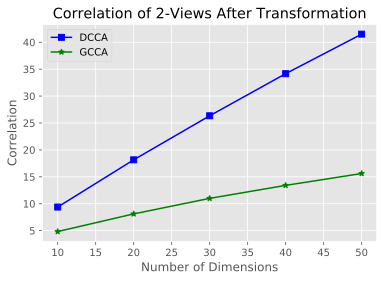

In [23]:
end_dims = results[0]
dcca_corrs_train = results[1]
dcca_corrs_test = results[2]
gcca_corrs_train = results[3]
gcca_corrs_test = results[4]

plt.figure()
plt.plot(end_dims, dcca_corrs_test, 'bs-')
plt.plot(end_dims, gcca_corrs_test, 'g*-')
plt.xlabel("Number of Dimensions")
plt.ylabel("Correlation")
plt.title("Correlation of 2-Views After Transformation")
plt.legend(("DCCA", "GCCA"))
plt.show()

## Experiment 2 from paper

In [24]:
view1_dict = sio.loadmat("XRMB/XRMBf2KALDI_window7_single1.mat")
view2_dict = sio.loadmat("XRMB/XRMBf2KALDI_window7_single2.mat")

In [35]:
X1_train = view1_dict["X1"]
X1_val = view1_dict["XV1"]
X1_test = view1_dict["XTe1"]
X2_train = view2_dict["X2"]
X2_val = view2_dict["XV2"]
X2_test = view2_dict["XTe2"]
train_label = view2_dict['trainLabel']
val_label = view2_dict['tuneLabel']
test_label = view2_dict['testLabel']

In [39]:
# Separate into training and testing
np.random.seed(1)

total_samp = X1_train.shape[0]
total_samp_val = X1_val.shape[0]
total_samp_test = X1_test.shape[0]
train_size = 70000
val_size = 10000
test_size = 10000

idx_train = np.random.rand(total_samp)
idx_train = np.where(idx_train < (train_size)/total_samp)
v1_train = X1_train[idx_train]
v2_train = X2_train[idx_train]
print(v1_train.shape)

idx_val = np.random.rand(total_samp_val)
idx_val = np.where(idx_val < (val_size)/total_samp_test)
v1_val = X1_val[idx_val]
v2_val = X2_val[idx_val]
print(v1_val.shape)

idx_test = np.random.rand(total_samp_test)
idx_test = np.where(idx_test < (test_size)/total_samp_test)
v1_test = X1_test[idx_test]
v2_test = X2_test[idx_test]
print(v1_test.shape)


# append it to data struct for code
data1 = []
data2 = []

data1.append((torch.tensor(v1_train.astype("double")), train_label))
data1.append((torch.tensor(v1_val.astype("double")), val_label))
data1.append((torch.tensor(v1_test.astype("double")), test_label))

data2.append((torch.tensor(v2_train.astype("double")), train_label))
data2.append((torch.tensor(v2_val.astype("double")), val_label))
data2.append((torch.tensor(v2_test.astype("double")), test_label))


(70100, 273)
(7827, 273)
(9877, 273)


In [40]:
# size of the input for view 1 and view 2
input_shape1 = 273
input_shape2 = 112

# number of layers with nodes in each one
# layer_sizes1 = [1024, 1024, 1024, outdim_size]
# layer_sizes2 = [1024, 1024, 1024, outdim_size]
outdim_size = 50
layer_sizes1 = [1641, outdim_size]
layer_sizes2 = [1769, outdim_size]

# the parameters for training the network
learning_rate = 1e-3
epoch_num = 10
batch_size = 800



In [41]:
results = loop_simulation(data1, data2, layer_sizes1, layer_sizes2, input_shape1, input_shape2)

[ INFO : 2020-02-14 16:56:26,440 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=273, out_features=1641, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1641, out_features=10, bias=True)
      )
    )
    (model2): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=112, out_features=1769, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1769, out_features=10, bias=True)
      )
    )
  )
)
[ INFO : 2020-02-14 16:56:26,445 ] - RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 1e-05
)
[ INFO : 2020-02-14 16:56:32,035 ] - Epoch 1: val_loss improved from 0.0000 to -6.1493, saving model to checkpoint.model
[ INFO : 2020-02-14 16:56:32,039 ] - Epoch 1/10 - time: 5.59 - training_loss: -5.0650 - val_loss: -6.1493
[ INF

Linear CCA started!
(70100, 112)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
[ INFO : 2020-02-14 16:57:34,848 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=273, out_features=1641, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1641, out_features=20, bias=True)
      )
    )
    (model2): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=112, out_features=1769, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1769, out_features=20, bias=True)
      )
    )
  )
)
[ INFO : 2020-02-14 16:57:34,853 ] - RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight

finished loop: 10


[ INFO : 2020-02-14 16:57:40,730 ] - Epoch 1: val_loss improved from 0.0000 to -9.6729, saving model to checkpoint.model
[ INFO : 2020-02-14 16:57:40,733 ] - Epoch 1/10 - time: 5.86 - training_loss: -7.7550 - val_loss: -9.6729
[ INFO : 2020-02-14 16:57:46,780 ] - Epoch 2: val_loss improved from -9.6729 to -11.3690, saving model to checkpoint.model
[ INFO : 2020-02-14 16:57:46,784 ] - Epoch 2/10 - time: 6.05 - training_loss: -8.7910 - val_loss: -11.3690
[ INFO : 2020-02-14 16:57:52,747 ] - Epoch 3: val_loss improved from -11.3690 to -12.6453, saving model to checkpoint.model
[ INFO : 2020-02-14 16:57:52,750 ] - Epoch 3/10 - time: 5.96 - training_loss: -9.7289 - val_loss: -12.6453
[ INFO : 2020-02-14 16:57:58,761 ] - Epoch 4: val_loss improved from -12.6453 to -13.4587, saving model to checkpoint.model
[ INFO : 2020-02-14 16:57:58,765 ] - Epoch 4/10 - time: 6.01 - training_loss: -10.4956 - val_loss: -13.4587
[ INFO : 2020-02-14 16:58:04,721 ] - Epoch 5: val_loss improved from -13.4587 to

Linear CCA started!
(70100, 112)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
[ INFO : 2020-02-14 16:58:44,171 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=273, out_features=1641, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1641, out_features=30, bias=True)
      )
    )
    (model2): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=112, out_features=1769, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1769, out_features=30, bias=True)
      )
    )
  )
)
[ INFO : 2020-02-14 16:58:44,175 ] - RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight

finished loop: 20


[ INFO : 2020-02-14 16:58:50,066 ] - Epoch 1: val_loss improved from 0.0000 to -12.8574, saving model to checkpoint.model
[ INFO : 2020-02-14 16:58:50,070 ] - Epoch 1/10 - time: 5.88 - training_loss: -10.3378 - val_loss: -12.8574
[ INFO : 2020-02-14 16:58:56,182 ] - Epoch 2: val_loss improved from -12.8574 to -14.9316, saving model to checkpoint.model
[ INFO : 2020-02-14 16:58:56,186 ] - Epoch 2/10 - time: 6.11 - training_loss: -11.6196 - val_loss: -14.9316
[ INFO : 2020-02-14 16:59:02,303 ] - Epoch 3: val_loss improved from -14.9316 to -16.5779, saving model to checkpoint.model
[ INFO : 2020-02-14 16:59:02,306 ] - Epoch 3/10 - time: 6.12 - training_loss: -12.8236 - val_loss: -16.5779
[ INFO : 2020-02-14 16:59:08,369 ] - Epoch 4: val_loss improved from -16.5779 to -17.9069, saving model to checkpoint.model
[ INFO : 2020-02-14 16:59:08,372 ] - Epoch 4/10 - time: 6.06 - training_loss: -13.8798 - val_loss: -17.9069
[ INFO : 2020-02-14 16:59:14,454 ] - Epoch 5: val_loss improved from -17.9

Linear CCA started!
(70100, 112)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
[ INFO : 2020-02-14 16:59:54,886 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=273, out_features=1641, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1641, out_features=40, bias=True)
      )
    )
    (model2): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=112, out_features=1769, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1769, out_features=40, bias=True)
      )
    )
  )
)
[ INFO : 2020-02-14 16:59:54,889 ] - RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight

finished loop: 30


[ INFO : 2020-02-14 17:00:01,132 ] - Epoch 1: val_loss improved from 0.0000 to -15.7064, saving model to checkpoint.model
[ INFO : 2020-02-14 17:00:01,137 ] - Epoch 1/10 - time: 6.23 - training_loss: -12.8658 - val_loss: -15.7064
[ INFO : 2020-02-14 17:00:07,699 ] - Epoch 2: val_loss improved from -15.7064 to -18.2774, saving model to checkpoint.model
[ INFO : 2020-02-14 17:00:07,702 ] - Epoch 2/10 - time: 6.56 - training_loss: -14.3109 - val_loss: -18.2774
[ INFO : 2020-02-14 17:00:14,261 ] - Epoch 3: val_loss improved from -18.2774 to -20.3725, saving model to checkpoint.model
[ INFO : 2020-02-14 17:00:14,264 ] - Epoch 3/10 - time: 6.56 - training_loss: -15.7085 - val_loss: -20.3725
[ INFO : 2020-02-14 17:00:20,937 ] - Epoch 4: val_loss improved from -20.3725 to -21.9625, saving model to checkpoint.model
[ INFO : 2020-02-14 17:00:20,941 ] - Epoch 4/10 - time: 6.68 - training_loss: -16.9567 - val_loss: -21.9625
[ INFO : 2020-02-14 17:00:27,544 ] - Epoch 5: val_loss improved from -21.9

Linear CCA started!
(70100, 112)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide
[ INFO : 2020-02-14 17:01:10,681 ] - DataParallel(
  (module): DeepCCA(
    (model1): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=273, out_features=1641, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1641, out_features=50, bias=True)
      )
    )
    (model2): MlpNet(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=112, out_features=1769, bias=True)
          (1): Sigmoid()
        )
        (1): Linear(in_features=1769, out_features=50, bias=True)
      )
    )
  )
)
[ INFO : 2020-02-14 17:01:10,684 ] - RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight

finished loop: 40


[ INFO : 2020-02-14 17:01:17,345 ] - Epoch 1: val_loss improved from 0.0000 to -19.2248, saving model to checkpoint.model
[ INFO : 2020-02-14 17:01:17,348 ] - Epoch 1/10 - time: 6.65 - training_loss: -15.6589 - val_loss: -19.2248
[ INFO : 2020-02-14 17:01:24,227 ] - Epoch 2: val_loss improved from -19.2248 to -21.8531, saving model to checkpoint.model
[ INFO : 2020-02-14 17:01:24,231 ] - Epoch 2/10 - time: 6.88 - training_loss: -17.2229 - val_loss: -21.8531
[ INFO : 2020-02-14 17:01:31,116 ] - Epoch 3: val_loss improved from -21.8531 to -23.9913, saving model to checkpoint.model
[ INFO : 2020-02-14 17:01:31,120 ] - Epoch 3/10 - time: 6.89 - training_loss: -18.7013 - val_loss: -23.9913
[ INFO : 2020-02-14 17:01:38,006 ] - Epoch 4: val_loss improved from -23.9913 to -25.5959, saving model to checkpoint.model
[ INFO : 2020-02-14 17:01:38,010 ] - Epoch 4/10 - time: 6.89 - training_loss: -20.0403 - val_loss: -25.5959
[ INFO : 2020-02-14 17:01:44,881 ] - Epoch 5: val_loss improved from -25.5

Linear CCA started!
(70100, 112)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide


finished loop: 50


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide


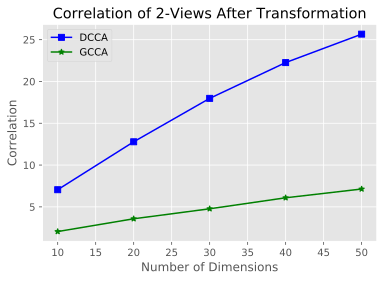

In [42]:
end_dims = results[0]
dcca_corrs_train = results[1]
dcca_corrs_test = results[2]
gcca_corrs_train = results[3]
gcca_corrs_test = results[4]

plt.figure()
plt.plot(end_dims, dcca_corrs_test, 'bs-')
plt.plot(end_dims, gcca_corrs_test, 'g*-')
plt.xlabel("Number of Dimensions")
plt.ylabel("Correlation")
plt.title("Correlation of 2-Views After Transformation")
plt.legend(("DCCA", "GCCA"))
plt.show()